# Purpose: Evaluating Kaggle.com's restaurant tip dataset

__Analysis: Measure the predictive power of the dataset's variables on the tip percentage of the bill.__

_Note: We won't measure the obvious predictive power of the bill to the tip dollar amount, but instead see if the other variables have any utility._

In [1]:
# load required modules

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#load the dataset
tips = pd.read_csv('tips.csv', low_memory=False)

__Exploratory Data Analysis:__

In [3]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
tips.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


In [5]:
tips['size'].value_counts()

size
2    156
3     38
4     37
5      5
1      4
6      4
Name: count, dtype: int64

In [6]:
tips.day.value_counts()

day
Sat     87
Sun     76
Thur    62
Fri     19
Name: count, dtype: int64


__Let's add variables to convert tip to percent tip, total bill to plate price, day of week to Weekday/Weekend, and group together party sizes of 4 or more.__

In [7]:
tips['p_tip'] = tips.tip / tips.total_bill
tips['plate_price'] = round(tips['total_bill'] / tips['size'])

def tip_bin_calc (row):
  if row['p_tip'] < 0.12: result = 'tip < 12%'
  elif row['p_tip'] < 0.15: result = '12% <= tip < 15%'
  elif row['p_tip'] < 0.20: result = '15% <= tip < 20%'
  else: result = 'tip >= 20%'
  return result

tips['tip_bin'] = tips.apply(tip_bin_calc, axis=1)

def weekday_calc (row):
  result = 'Weekday'
  if row['day'] in ['Sat','Sun']: result = 'Weekend'
  return result

tips['weekday'] = tips.apply(weekday_calc, axis=1)

def party_calc (row):
  result = row['size']
  if row['size'] > 4: result = 4
  return result

tips['party'] = tips.apply(party_calc, axis=1)



In [8]:
tips.dtypes

total_bill     float64
tip            float64
sex             object
smoker          object
day             object
time            object
size             int64
p_tip          float64
plate_price    float64
tip_bin         object
weekday         object
party            int64
dtype: object

In [9]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,p_tip,plate_price,tip_bin,weekday,party
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,8.0,tip < 12%,Weekend,2
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,3.0,15% <= tip < 20%,Weekend,3
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,7.0,15% <= tip < 20%,Weekend,3
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,12.0,12% <= tip < 15%,Weekend,2
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,6.0,12% <= tip < 15%,Weekend,4


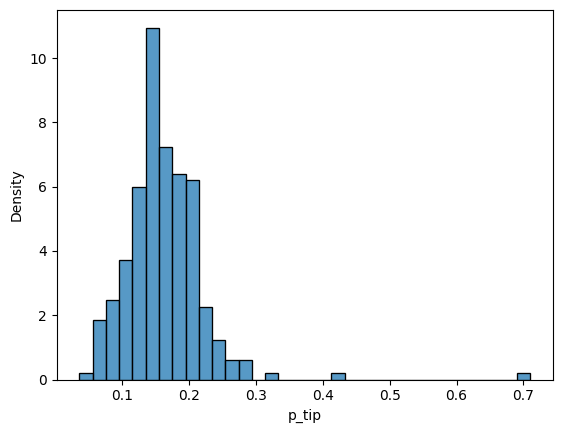

<Figure size 640x480 with 0 Axes>

In [10]:
plt.clf()
sns.histplot(tips.p_tip, stat='density')

plt.show()
plt.clf()

In [11]:
mean_tip = np.mean(tips.p_tip)
stdev_tip = np.std(tips.p_tip)
print('mean tip %:',round(mean_tip*100,2), 'tip % standard deviation',round(stdev_tip,3))

mean tip %: 16.08 tip % standard deviation 0.061


In [12]:
tip_sum = tips.groupby(['sex','smoker','time','party','plate_price','weekday'], group_keys=False).p_tip.mean().reset_index()

In [13]:
tip_sum.head()

,sex,smoker,time,party,plate_price,weekday,p_tip
0,Female,No,Dinner,1,7.0,Weekend,0.137931
1,Female,No,Dinner,2,5.0,Weekend,0.252672
2,Female,No,Dinner,2,7.0,Weekend,0.182639
3,Female,No,Dinner,2,8.0,Weekend,0.137552
4,Female,No,Dinner,2,9.0,Weekday,0.159744


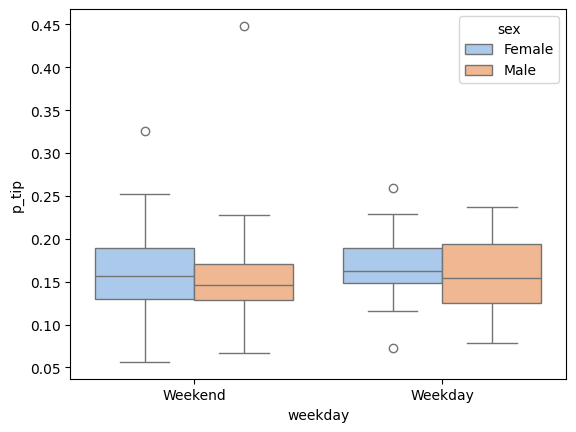

In [14]:
sns.boxplot(x = 'weekday', y = 'p_tip', hue='sex', palette = 'pastel', data = tip_sum)
plt.show()

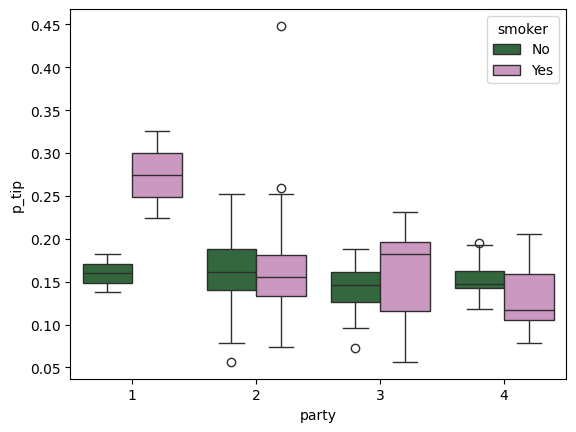

In [15]:
sns.boxplot(x = 'party', y = 'p_tip', hue='smoker', palette = 'cubehelix', data = tip_sum)
plt.show()

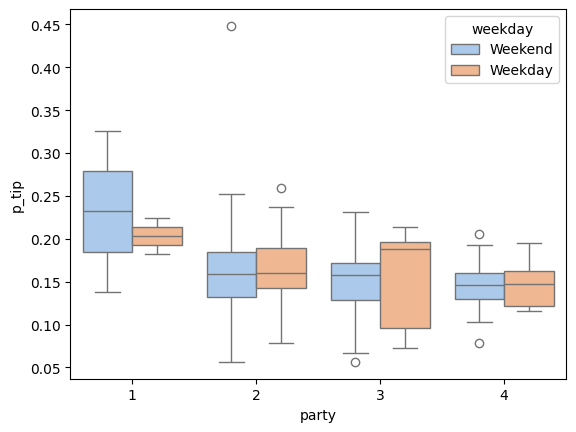

In [16]:
sns.boxplot(x = 'party', y = 'p_tip', hue='weekday', palette = 'pastel', data = tip_sum)
plt.show()

__Let's convert the categorical data into numbers to prepare for processing. We'll create both an array of tip categories (tip_bins) for Bayesian analysis, and an array of tip percentages (p_tips) for a linear regression.__

In [17]:
tips_nums = tips

sex_nums = []
smoker_nums = []
time_nums = []
weekday_nums = []
p_tips = []
tip_bins = []
column_names = ['sex','smoker','time','party','plate_price','weekday']


for ind, row in tips_nums.iterrows():
    if row['sex'] == 'Female': sex_nums.append(0)
    else: sex_nums.append(1)

    if row['smoker'] == 'No': smoker_nums.append(0)
    else: smoker_nums.append(1)

    if row['time'] == 'Lunch': time_nums.append(0)
    else: time_nums.append(1)

    if row['weekday'] == 'Weekday': weekday_nums.append(0)
    else: weekday_nums.append(1)

    p_tips.append(round(row['p_tip']*100))
    tip_bins.append(row['tip_bin'])

tips_nums['sex'] = sex_nums
tips_nums['smoker'] = smoker_nums
tips_nums['time'] = time_nums
tips_nums['weekday'] = weekday_nums

tips_nums = tips_nums[column_names]


In [18]:
tips_nums.head()

,sex,smoker,time,party,plate_price,weekday
0,0,0,1,2,8.0,1
1,1,0,1,3,3.0,1
2,1,0,1,3,7.0,1
3,1,0,1,2,12.0,1
4,0,0,1,4,6.0,1


__Now Let's apply a Naive Bayes classifier to predict the tip category:__

In [19]:
x_train, x_test, y_train, y_test = train_test_split(tips_nums, tip_bins, test_size=0.33, random_state = 44)

In [20]:
#Convert pandas dataframes into numpy arrays (it is needed for the fitting)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [21]:
tips_nums.shape

(244, 6)

In [22]:
x_train.shape

(163, 6)

In [23]:
y_train.shape

(163,)

In [24]:
x_test.shape

(81, 6)

In [25]:
y_test.shape

(81,)

In [26]:
# Create a Naive Bayes classifier
clf = GaussianNB()

# Train the classifier using the training data
clf.fit(x_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(x_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.37037037037037035


__That's a poor accuracy score. Let's try a Linear regression of the numeric tip percentages.__

In [27]:
x_train, x_test, y_train, y_test = train_test_split(tips_nums, p_tips, test_size=0.33, random_state = 44)

#Convert pandas dataframes into numpy arrays (it is needed for the fitting)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#Create and fit the model
model = LinearRegression()

#Fit the model using the training data
model.fit(x_train,y_train)

#Predict unseen data
y_predicted =model.predict(x_test)
scores = model.score(x_test, y_test)
r2 = r2_score(y_test, y_predicted)
print('r2',r2)

print(scores)

r2 -0.3016302259023178
-0.3016302259023178


__That's actually worse than just predicting the tip percentage is always 15%!__

### Conclusion: Unfortunately, we've found that the dataset's meal and customer data are not predictive of the size of the tip customer's leave. ###